<a href="https://colab.research.google.com/github/Elma-dev/build_gpt_from_scratch/blob/main/build_llm_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [ ]:
# q: quit mode
! pip install tiktoken -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00


# Import

In [ ]:
# import pytorch module
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset,DataLoader

In [ ]:
# import tiktoken
import tiktoken

# Code

In [ ]:
# Build data reader
def data_reader(file_path:str):
  with open(file_path, 'r', encoding='utf-8') as f:
    data = f.read()
  return data

In [ ]:
# create a data set creator
class DatasetV1(Dataset):
  def __init__(self,text,tokenizer,max_length,stride=1):
    self.tokenizer=tokenizer
    self.input_ids=[]
    self.target_ids=[]
    ids=tokenizer.encode(text)

    for i in range(0,len(ids)-max_length,stride):
      inp=ids[i:i+max_length]
      out=ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(inp))
      self.target_ids.append(torch.tensor(out))
  def __len__(self):
    return len(self.input_ids)
  def __getitem__(self,idx):
    return self.input_ids[idx],self.target_ids[idx]

In [ ]:
# test:
# create tokenizer
tokenizer=tiktoken.get_encoding("gpt2")
# read data
text=data_reader("the-verdict.txt")
# create A dataset creator
dataset=DatasetV1(text,tokenizer,8,1)

In [ ]:
# get some items
dataset[0]

(tensor([  40,  367, 2885, 1464, 1807, 3619,  402,  271]),
 tensor([  367,  2885,  1464,  1807,  3619,   402,   271, 10899]))

In [ ]:
# create DataLoader " torch dataloader gives us the ability to create data batches and other features"
def data_loader(text,max_length=256,stride=128,batch_size=4,shuffle=True,drop_last=True):
  # create tokenizer
  tokenizer=tiktoken.get_encoding("gpt2")
  #create dataset
  dataset=DatasetV1(text,tokenizer,max_length,stride)
  #create data loader
  data_loader_=DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last)
  return data_loader_

In [ ]:
data_loader_=data_loader(text,max_length=8,stride=1,shuffle=False,drop_last=False)

In [ ]:
#iterate batches: test with the first one
data_loader_iter=iter(data_loader_)
next(data_loader_iter)

[tensor([[   40,   367,  2885,  1464,  1807,  3619,   402,   271],
         [  367,  2885,  1464,  1807,  3619,   402,   271, 10899],
         [ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138],
         [ 1464,  1807,  3619,   402,   271, 10899,  2138,   257]]),
 tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899],
         [ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138],
         [ 1464,  1807,  3619,   402,   271, 10899,  2138,   257],
         [ 1807,  3619,   402,   271, 10899,  2138,   257,  7026]])]

## Creating Token embedding
* token -> ids -> embed_vectors

In [ ]:
# create embedder
vocab_size=6
out_size= 3 # means each vocab has a vector of 3 as an embedd
embed_mat=nn.Embedding(vocab_size,out_size)
print(f"the embedding of the word has 3 as id is {embed_mat(torch.tensor([3]))}")
embed_mat.weight

the embedding of the word has 3 as id is tensor([[0.4011, 0.2451, 0.2429]], grad_fn=<EmbeddingBackward0>)


Parameter containing:
tensor([[ 1.3343e+00, -6.4121e-01, -4.0116e-01],
        [ 1.5447e+00,  2.0123e+00, -8.7758e-01],
        [ 5.3385e-01, -3.6142e-01,  9.4338e-01],
        [ 4.0107e-01,  2.4508e-01,  2.4288e-01],
        [ 1.5350e+00, -1.1164e+00,  1.3175e-03],
        [ 3.3558e-01, -9.9902e-01,  2.0132e-01]], requires_grad=True)

## Creating Positional Embeddings
 * in this part we will use absolute positional embedding
 * The positional embedding matrix will have this params:

  P(max_size,embed_size)


In [ ]:
# example of positional Embedding
max_size=8
embed_size=4
positional_embedding=nn.Embedding(8,4)
positional_embedding.weight

Parameter containing:
tensor([[-2.3837, -0.3129,  0.1458, -0.2609],
        [ 0.7013,  0.3002,  1.6215,  1.3261],
        [ 0.2828,  1.1381,  1.1745,  1.0493],
        [-1.5828,  0.3414,  0.3212,  0.0322],
        [-0.5921,  1.6416,  0.8777,  0.1340],
        [-0.2796,  0.7418,  0.6964,  1.0178],
        [-0.2491,  0.2329, -0.7686, -0.2199],
        [-0.5151, -1.3687, -0.7718,  1.6710]], requires_grad=True)

## Part1: Positional Embedding + Word Embedding

In [ ]:
class ModelParams:
  def __init__(self):
    self.max_size=4
    self.embedding_size=256
    self.batch_size=8
    self.vocab_size=50257
model_params=ModelParams()

In [ ]:
# create data loader
data_loder_=data_loader(text,
            max_length=model_params.max_size,
            stride=model_params.max_size,
            batch_size=model_params.batch_size,
            shuffle=False,
            drop_last=False
            )
# create word Embedding layer
word_embedding=nn.Embedding(
    model_params.vocab_size,
    model_params.embedding_size)
# create positional Embedding layer
position_embedding=nn.Embedding(
    model_params.max_size,
    model_params.embedding_size
)

In [ ]:
data_loader_iter=iter(data_loder_)
input_1=next(data_loader_iter)
input_1[0]

tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

In [ ]:
word_embedding(input_1[0][0])[0].shape

torch.Size([256])

In [ ]:
position_embedding(torch.arange(model_params.max_size)).shape

torch.Size([4, 256])

# Attentions:
  * Self attention
  * Causal Attention
  * Multy head Attentions

##Self Attention without params:

In [ ]:
prompt="your journey start with one step"
ids=tokenizer.encode(prompt)
embed_matx=nn.Embedding(len(ids),3)

In [ ]:
# embedding of prompt
embed_matx.weight

Parameter containing:
tensor([[ 0.5890, -0.0397, -0.7609],
        [ 0.1237, -1.3715,  0.5509],
        [-0.3006,  0.3211, -0.1528],
        [ 0.6615, -1.0712, -0.1668],
        [-0.4502,  0.9853,  3.0188],
        [-0.9370, -0.0070,  0.7737]], requires_grad=True)

In [ ]:
#attention of each token with others example: x1,xi
# Attrntion Score
attentions=embed_matx.weight @ embed_matx.weight.T
attentions

tensor([[ 9.2753e-01, -2.9186e-01, -7.3548e-02,  5.5907e-01, -2.6014e+00,
         -1.1404e+00],
        [-2.9186e-01,  2.1999e+00, -5.6169e-01,  1.4591e+00,  2.5596e-01,
          3.1988e-01],
        [-7.3548e-02, -5.6169e-01,  2.1677e-01, -5.1725e-01, -9.5418e-03,
          1.6121e-01],
        [ 5.5907e-01,  1.4591e+00, -5.1725e-01,  1.6128e+00, -1.8568e+00,
         -7.4139e-01],
        [-2.6014e+00,  2.5596e-01, -9.5418e-03, -1.8568e+00,  1.0287e+01,
          2.7507e+00],
        [-1.1404e+00,  3.1988e-01,  1.6121e-01, -7.4139e-01,  2.7507e+00,
          1.4767e+00]], grad_fn=<MmBackward0>)

In [ ]:
# normalization of attention matrix
#attention weight
norm_att=torch.softmax(attentions,dim=0)
norm_att

tensor([[3.9833e-01, 4.3143e-02, 1.6883e-01, 1.4224e-01, 2.5260e-06, 1.3673e-02],
        [1.1767e-01, 5.2126e-01, 1.0362e-01, 3.4986e-01, 4.3992e-05, 5.8893e-02],
        [1.4638e-01, 3.2940e-02, 2.2571e-01, 4.8482e-02, 3.3734e-05, 5.0252e-02],
        [2.7556e-01, 2.4851e-01, 1.0833e-01, 4.0797e-01, 5.3190e-06, 2.0378e-02],
        [1.1686e-02, 7.4615e-02, 1.7999e-01, 1.2701e-02, 9.9938e-01, 6.6953e-01],
        [5.0367e-02, 7.9540e-02, 2.1351e-01, 3.8747e-02, 5.3314e-04, 1.8727e-01]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
norm_att@embed_matx.weight

tensor([[ 0.2705, -0.1732, -0.3183],
        [ 0.2789, -1.0615,  0.1691],
        [ 0.0074, -0.0308, -0.0968],
        [ 0.4113, -0.7541, -0.1416],
        [-1.1069,  0.9214,  3.5376],
        [-0.1748, -0.0848,  0.1129]], grad_fn=<MmBackward0>)

In [ ]:
embed_matx.weight

Parameter containing:
tensor([[ 0.5890, -0.0397, -0.7609],
        [ 0.1237, -1.3715,  0.5509],
        [-0.3006,  0.3211, -0.1528],
        [ 0.6615, -1.0712, -0.1668],
        [-0.4502,  0.9853,  3.0188],
        [-0.9370, -0.0070,  0.7737]], requires_grad=True)

## Self Attention with Weights
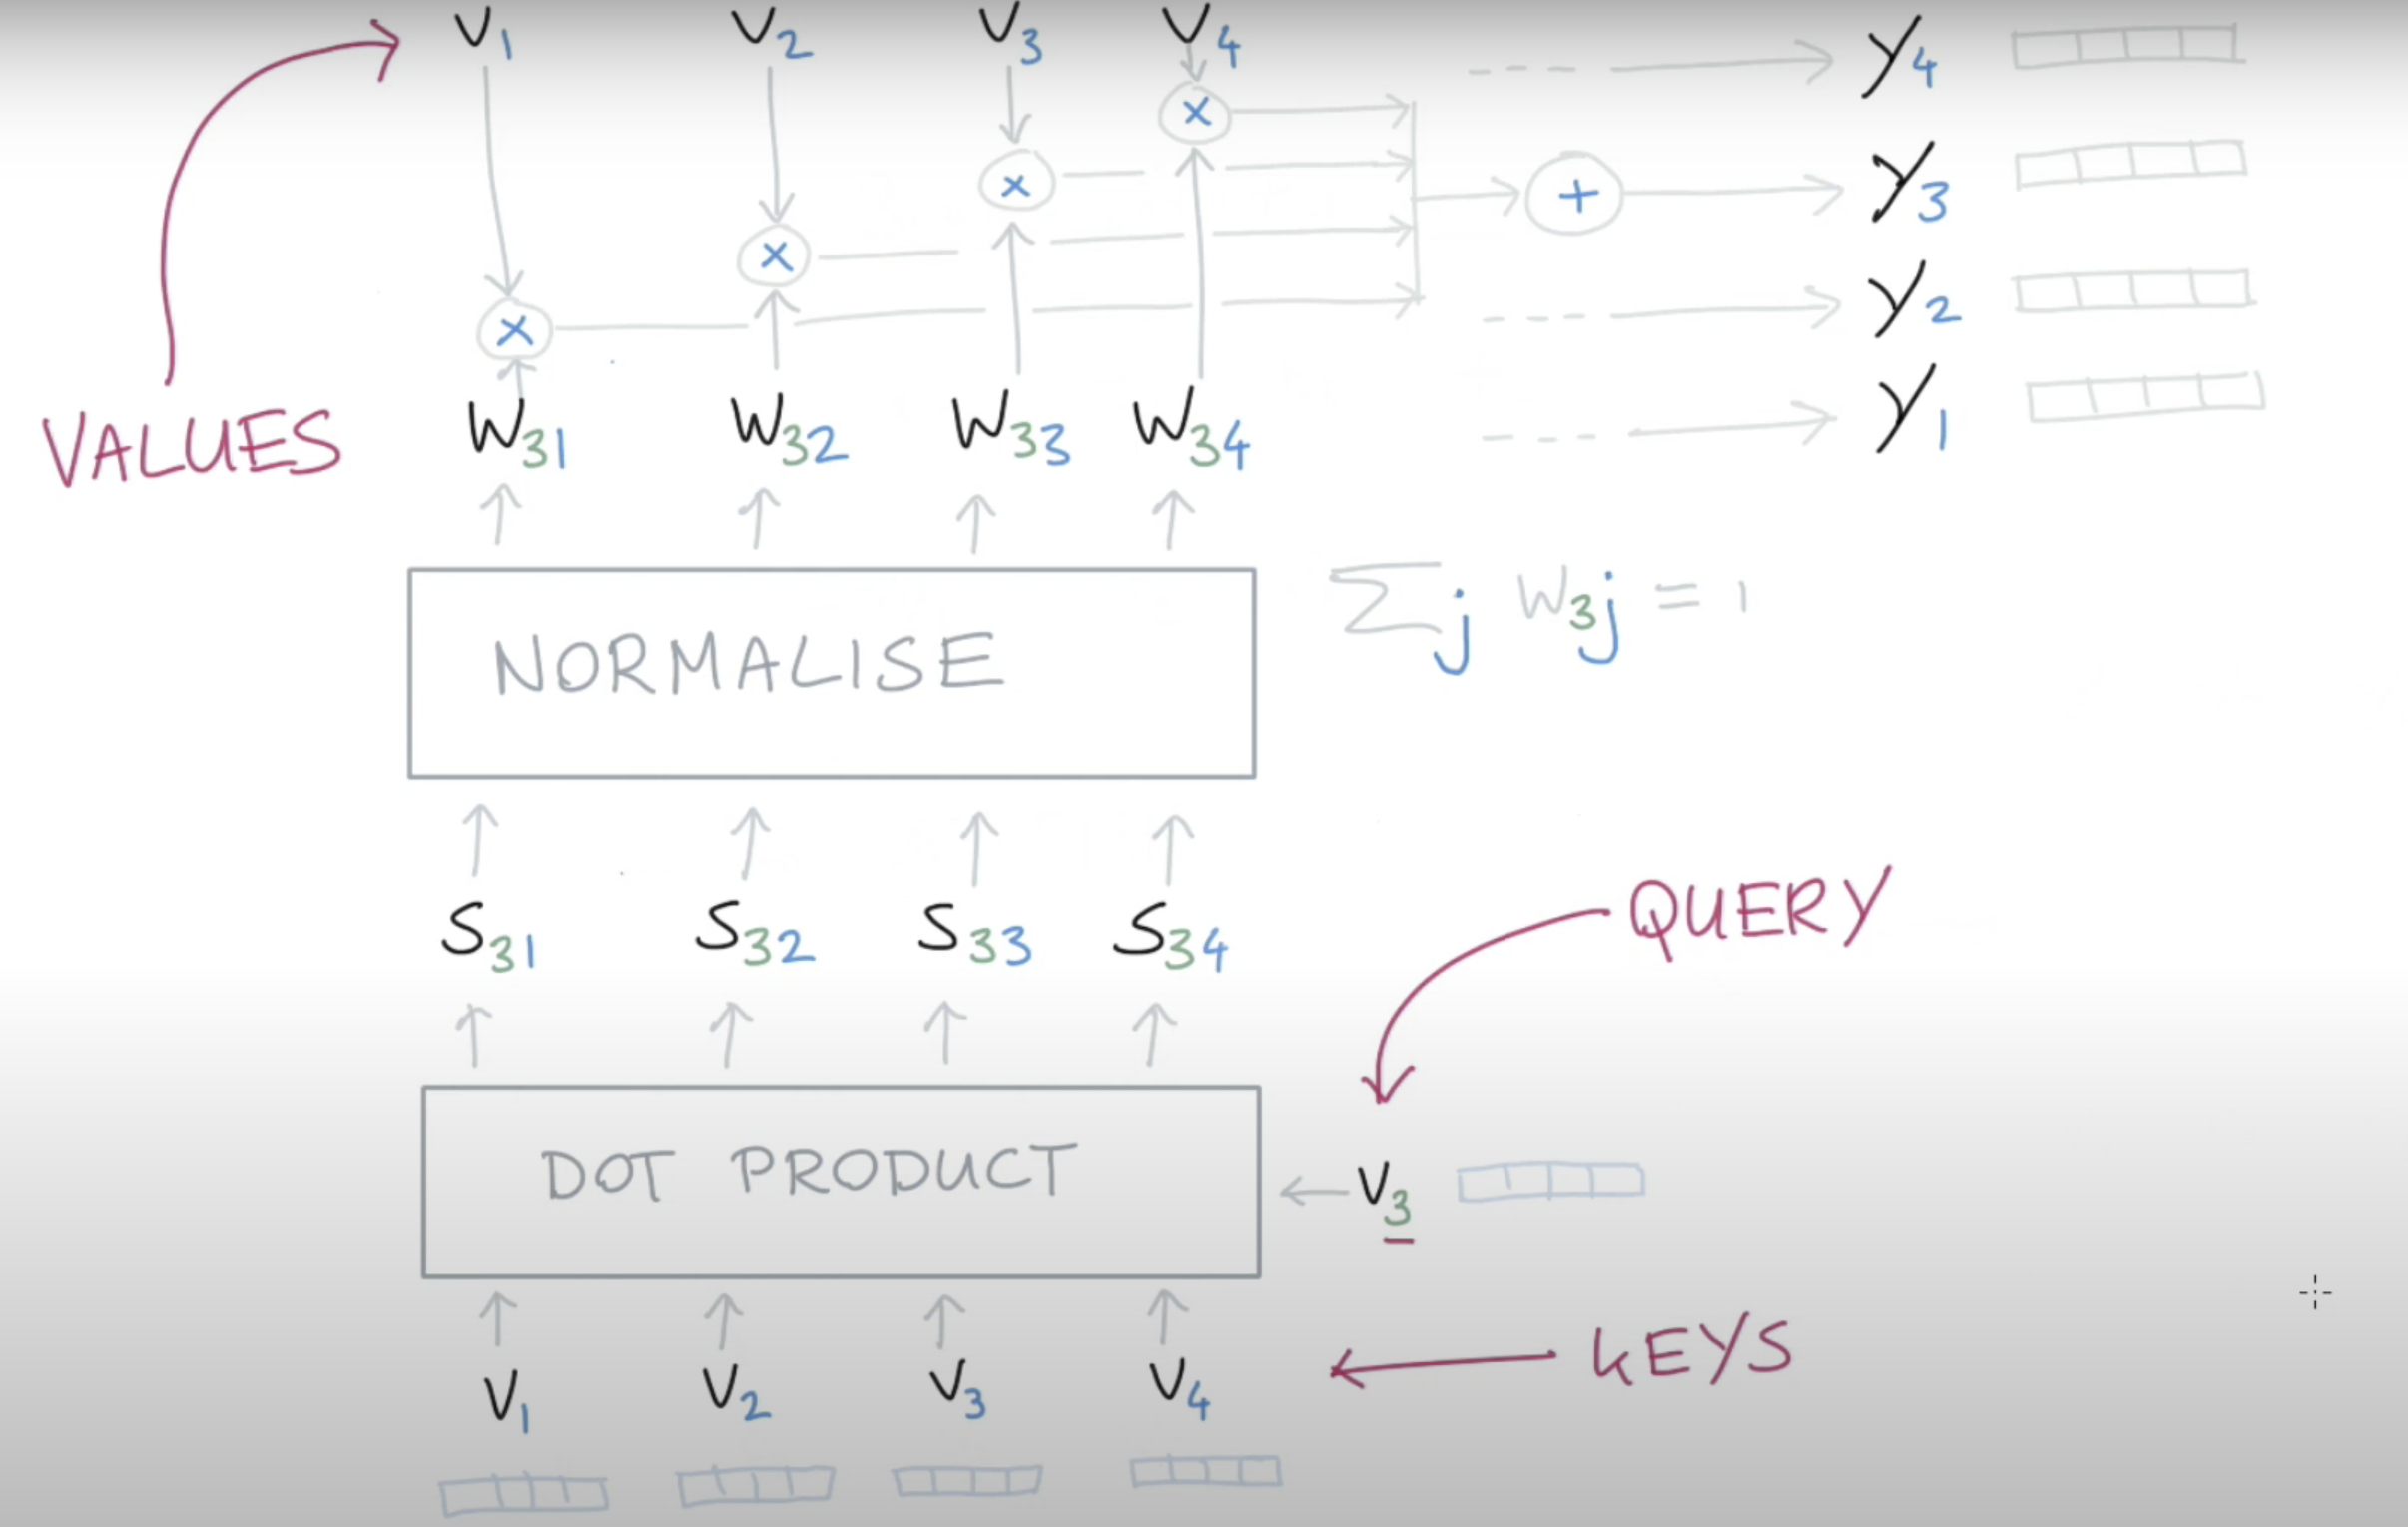

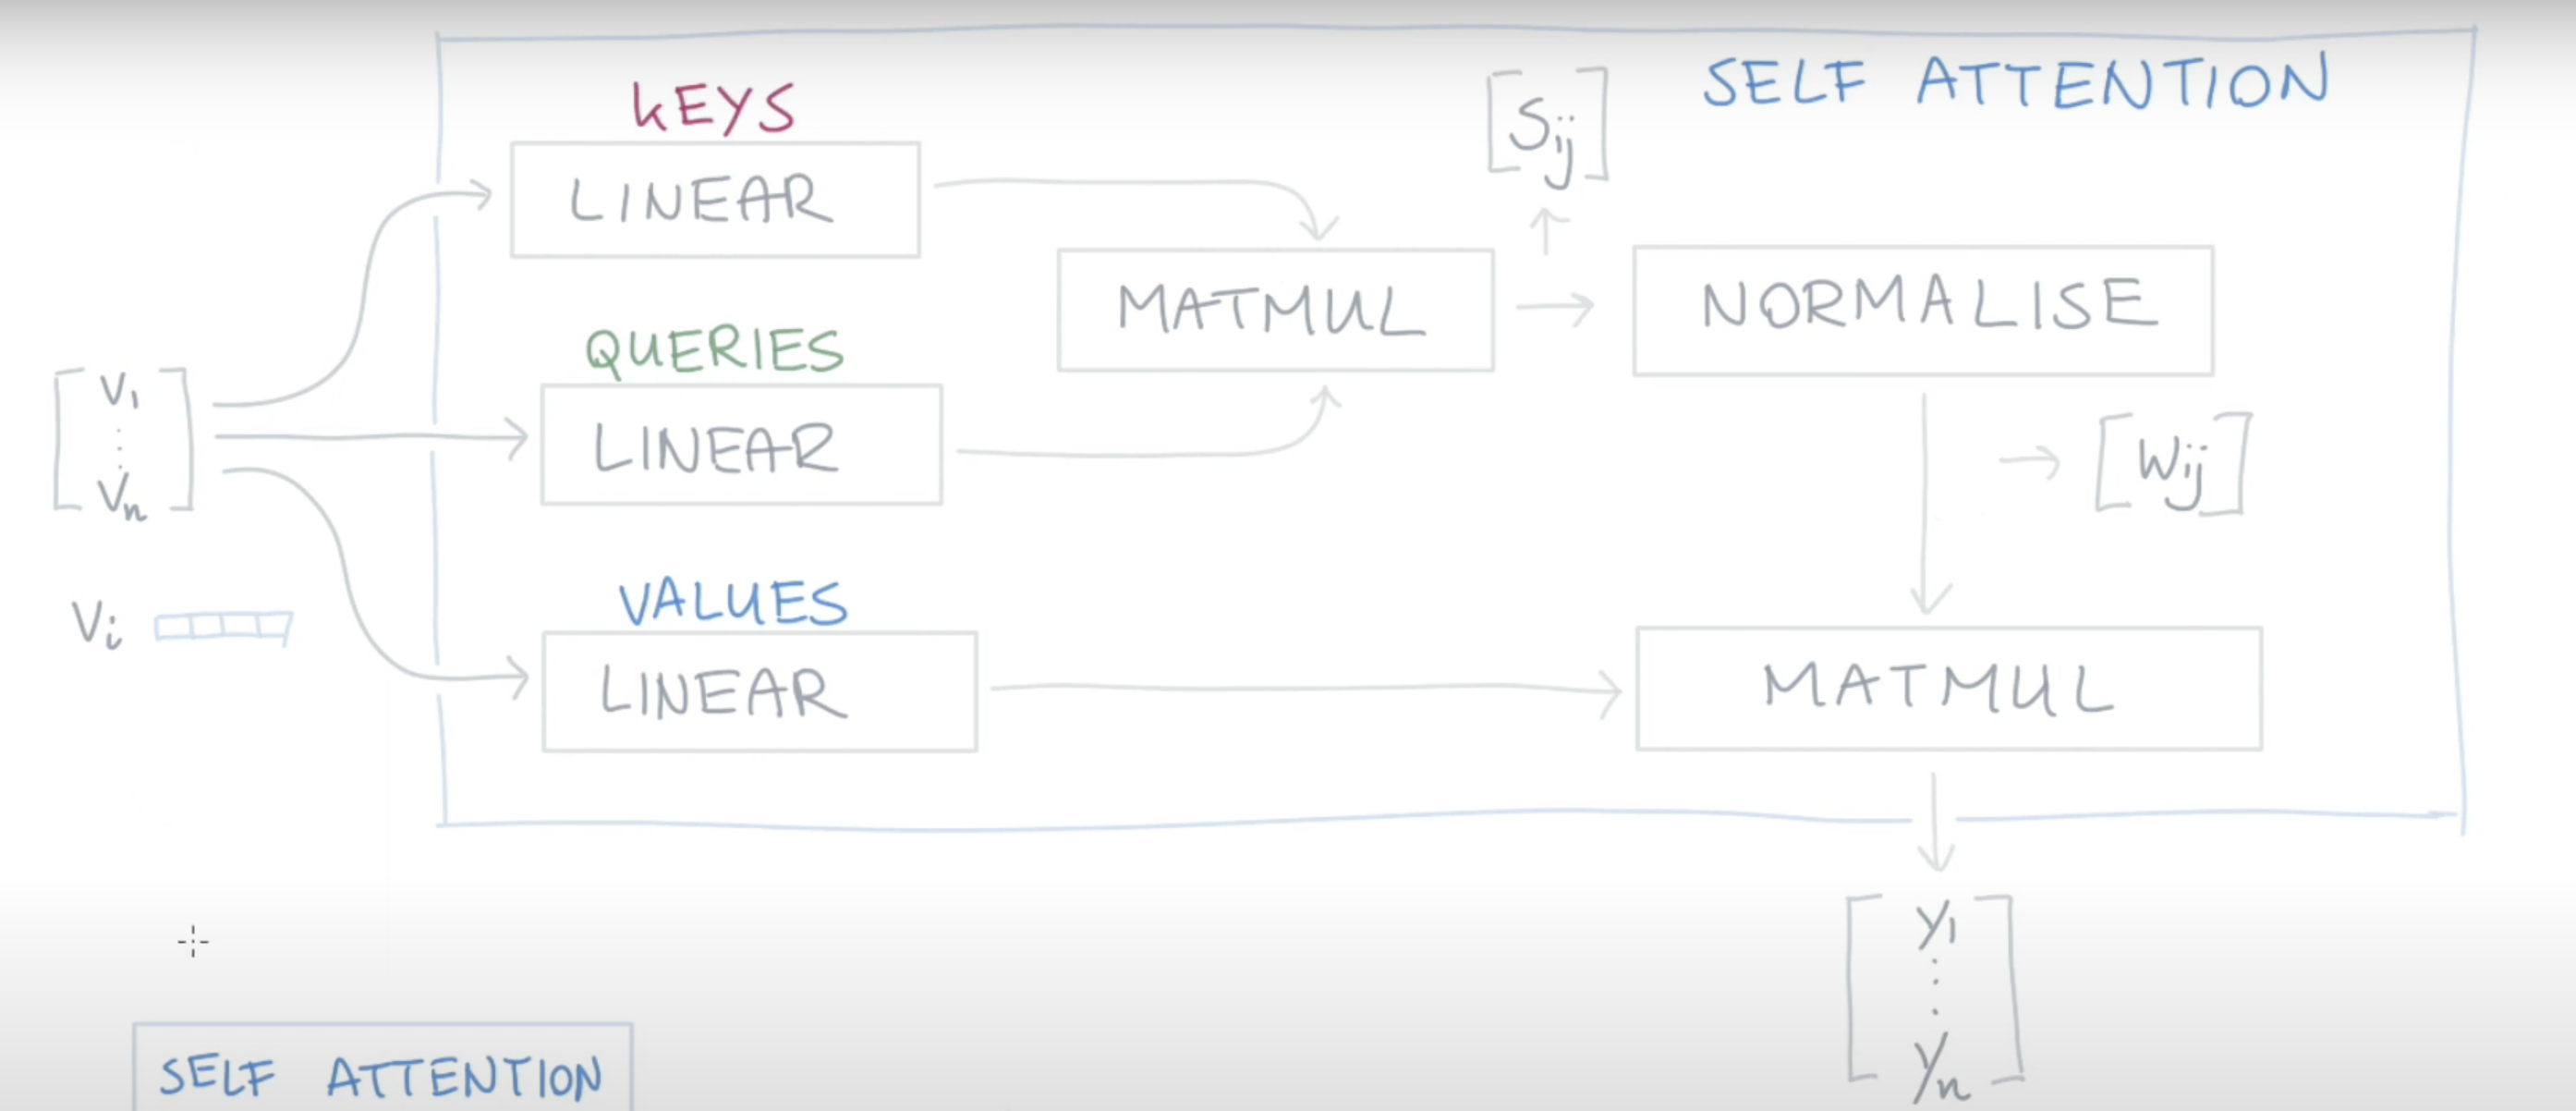

In [ ]:
embed_mat.weight

Parameter containing:
tensor([[ 1.3343e+00, -6.4121e-01, -4.0116e-01],
        [ 1.5447e+00,  2.0123e+00, -8.7758e-01],
        [ 5.3385e-01, -3.6142e-01,  9.4338e-01],
        [ 4.0107e-01,  2.4508e-01,  2.4288e-01],
        [ 1.5350e+00, -1.1164e+00,  1.3175e-03],
        [ 3.3558e-01, -9.9902e-01,  2.0132e-01]], requires_grad=True)

In [ ]:
# let's take e3 as query
x_3=embed_mat.weight[2]

In [ ]:
# create the query, key and val params ==> .shape[0] == x_3.shape[0]
in_dim=x_3.shape[0]
out_dim=2

In [ ]:
w_key=torch.nn.Parameter(torch.randn(in_dim,out_dim),requires_grad=False)
w_query=torch.nn.Parameter(torch.randn(in_dim,out_dim),requires_grad=False)
w_val=torch.nn.Parameter(torch.randn(in_dim,out_dim),requires_grad=False)

In [ ]:
print(w_key)
print(w_query)
print(w_val)

Parameter containing:
tensor([[ 1.1060,  0.2610],
        [-1.1551,  1.0123],
        [ 0.5837,  0.1718]])
Parameter containing:
tensor([[ 0.1344,  0.0738],
        [ 0.0102,  1.4525],
        [-1.1060, -0.4015]])
Parameter containing:
tensor([[ 0.1813, -0.4212],
        [-1.2512,  0.1913],
        [-0.2427, -1.5767]])


In [ ]:
# in_embed --> key_linear
in_key=embed_mat.weight @ w_key
# input_3: query --> query_linear
in3_query=x_3 @ w_query

print(f"inputs --> key_linear: {in_key}")
print(f"input3:query --> query_linear: {in3_query}")


inputs --> key_linear: tensor([[ 1.9822, -0.3698],
        [-1.1283,  2.2894],
        [ 1.5586, -0.0645],
        [ 0.3022,  0.3945],
        [ 2.9880, -0.7292],
        [ 1.6427, -0.8891]], grad_fn=<MmBackward0>)
input3:query --> query_linear: tensor([-0.9753, -0.8644], grad_fn=<SqueezeBackward4>)


In [ ]:
# dot product
in_kq=in3_query @ in_key.T
print(f"the attention scores between x3 and other key {in_kq}")

the attention scores between x3 and other key tensor([-1.6137, -0.8785, -1.4644, -0.6358, -2.2840, -0.8336],
       grad_fn=<SqueezeBackward4>)


In [ ]:
# Normalization
norm_in_kq=F.softmax(in_kq,dim=-1)
norm_in_kq

tensor([0.1042, 0.2173, 0.1209, 0.2770, 0.0533, 0.2273],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
# inputs as a values
in_val=embed_mat.weight @ w_val
in_val

tensor([[ 1.1416, -0.0522],
        [-2.0247,  1.1180],
        [ 0.3200, -1.7814],
        [-0.2929, -0.5050],
        [ 1.6749, -0.8622],
        [ 1.2620, -0.6499]], grad_fn=<MmBackward0>)

In [ ]:
norm_in_kq @ in_val

tensor([ 0.0126, -0.3115], grad_fn=<SqueezeBackward4>)

In [ ]:
sum=0
for k,v in enumerate(norm_in_kq):
    sum+=v*in_val[k]
sum

tensor([ 0.0126, -0.3115], grad_fn=<AddBackward0>)

## Build Compact Self Attention class
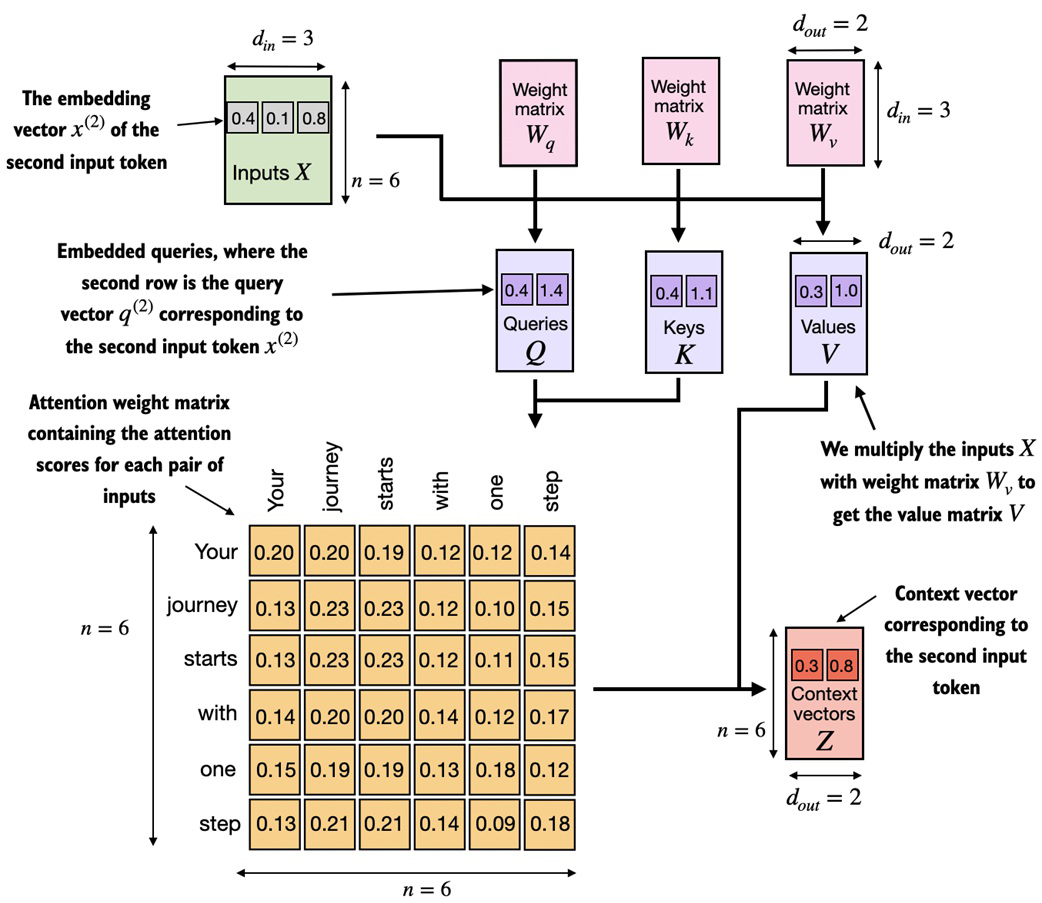

In [ ]:
class SelfAttention_v1(nn.Module):
  def __init__(self,in_d,out_d):
    super().__init__()
    self.in_dim=in_d
    self.out_dim=out_dim
    self.W_key=nn.Parameter(torch.randn(self.in_dim,self.out_dim))
    self.W_query=nn.Parameter(torch.randn(self.in_dim,self.out_dim))
    self.W_value=nn.Parameter(torch.randn(self.in_dim,self.out_dim))

  def forward(self,X):
    att_weights=self.__attentions_scores(X)
    return self.__vect_context(att_weights,X)

  def __attentions_scores(self,X):
    queries = X @ self.W_query
    keys = X @ self.W_key
    scores=queries @ keys.T
    norm_scores=torch.softmax(scores/keys.shape[-1]**0.5,dim=-1)
    return norm_scores

  def __vect_context(self,att_weights,X):
    values=X@self.W_value
    return att_weights @ values

In [ ]:
self_att=SelfAttention_v1(3,2)
self_att.forward(embed_mat.weight)

tensor([[ 0.0632,  0.8044],
        [-0.3773,  0.6650],
        [ 0.3605,  0.2181],
        [ 0.2972,  0.1925],
        [ 0.1133,  0.8135],
        [ 0.1908,  0.4873]], grad_fn=<MmBackward0>)

### Self Attention With Pytorch

In [ ]:
class SelfAttention_v2(nn.Module):
  def __init__(self,in_d,out_d,b_qkv=False):
    super().__init__()
    self.in_dim=in_d
    self.out_dim=out_d
    self.w_key=nn.Linear(in_d,out_d,b_qkv)
    self.w_query=nn.Linear(in_d,out_d,b_qkv)
    self.w_value=nn.Linear(in_d,out_d,b_qkv)
  def forward(self,X):
    scores_weights=self.__attentions_scores(X)
    context_vects=self.__context_vects(scores_weights,X)
    return context_vects
  def __attentions_scores(self,X):
    queries=self.w_query(X)
    keys=self.w_key(X)
    scores=queries @ keys.T
    weights=torch.softmax(scores/keys.shape[-1]**0.5,dim=-1)
    return weights
  def __context_vects(self,weights,X):
    values=self.w_value(X)
    return weights@values

In [ ]:
self_att_v2=SelfAttention_v2(3,2)
self_att_v2.forward(embed_mat.weight)

tensor([[0.5876, 0.0132],
        [0.4158, 0.0462],
        [0.5291, 0.0182],
        [0.5250, 0.0215],
        [0.5935, 0.0110],
        [0.6054, 0.0084]], grad_fn=<MmBackward0>)

## Causual Self Attention : Masked Attention
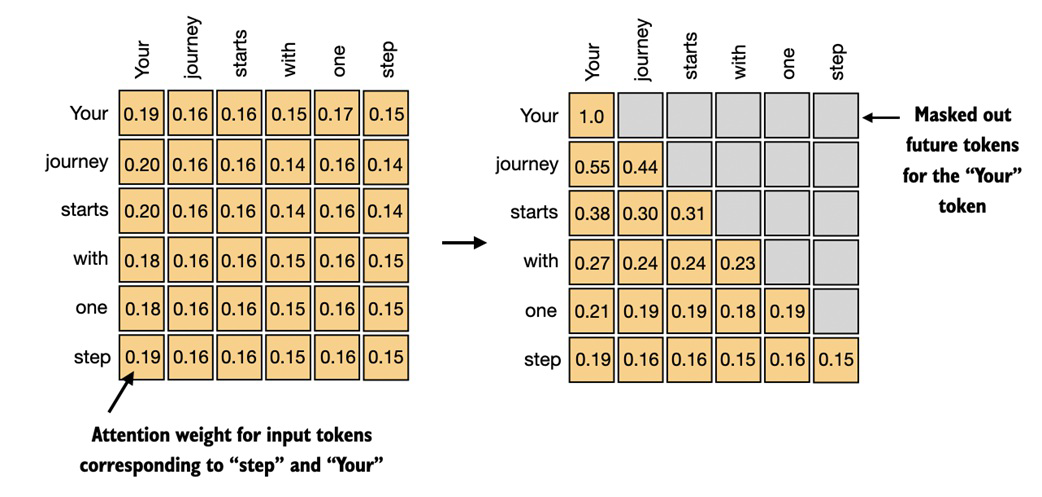

To Implement the causual SA we need to follow next schema:
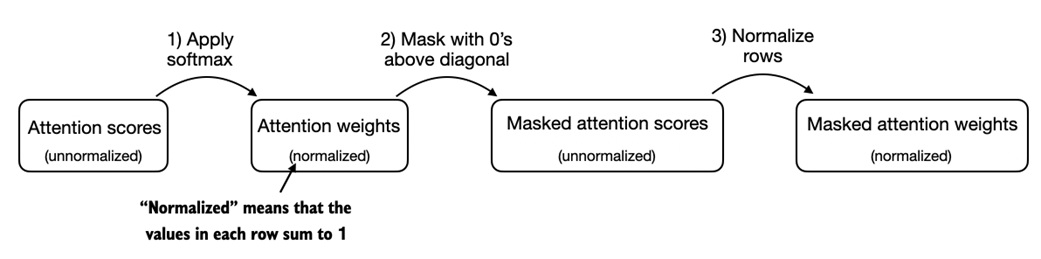

In [ ]:
1# calculate attentions weightd with Self
context_lenght=embed_mat.weight.shape[0]
in_dim,out_dim=embed_mat.weight.shape[1],embed_mat.weight.shape[0]
w_key=nn.Linear(in_dim,out_dim)
w_query=nn.Linear(in_dim,out_dim)
# calculate attentions weight
keys=w_key(embed_mat.weight)
queries=w_query(embed_mat.weight)
attention_scores=queries @ keys.T
# calculate attention weights
attention_weights=torch.softmax(attention_scores/context_lenght**0.5,dim=-1)
print(attention_weights)

tensor([[0.1756, 0.1755, 0.1526, 0.1605, 0.1712, 0.1646],
        [0.1491, 0.2654, 0.1625, 0.1549, 0.1549, 0.1131],
        [0.1531, 0.1793, 0.1724, 0.1820, 0.1450, 0.1682],
        [0.1591, 0.1855, 0.1689, 0.1718, 0.1563, 0.1585],
        [0.1728, 0.1719, 0.1535, 0.1661, 0.1643, 0.1715],
        [0.1735, 0.1483, 0.1580, 0.1676, 0.1669, 0.1857]],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
2# generate tril matrix
mask_mat=torch.tril(torch.ones((context_lenght,context_lenght)))
print(mask_mat)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [ ]:
masked_attention_scores=attention_weights * mask_mat
print(masked_attention_scores)

tensor([[0.1756, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1491, 0.2654, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1531, 0.1793, 0.1724, 0.0000, 0.0000, 0.0000],
        [0.1591, 0.1855, 0.1689, 0.1718, 0.0000, 0.0000],
        [0.1728, 0.1719, 0.1535, 0.1661, 0.1643, 0.0000],
        [0.1735, 0.1483, 0.1580, 0.1676, 0.1669, 0.1857]],
       grad_fn=<MulBackward0>)


In [ ]:
masked_attention_scores[masked_attention_scores==0]=-torch.inf

In [ ]:
#softmax(-00)=0
print(masked_attention_scores)

tensor([[0.1756,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1491, 0.2654,   -inf,   -inf,   -inf,   -inf],
        [0.1531, 0.1793, 0.1724,   -inf,   -inf,   -inf],
        [0.1591, 0.1855, 0.1689, 0.1718,   -inf,   -inf],
        [0.1728, 0.1719, 0.1535, 0.1661, 0.1643,   -inf],
        [0.1735, 0.1483, 0.1580, 0.1676, 0.1669, 0.1857]],
       grad_fn=<IndexPutBackward0>)


In [ ]:
masked_attention_weights=torch.softmax(masked_attention_scores,dim=1)
masked_attention_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4710, 0.5290, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3283, 0.3370, 0.3347, 0.0000, 0.0000, 0.0000],
        [0.2470, 0.2536, 0.2494, 0.2501, 0.0000, 0.0000],
        [0.2014, 0.2012, 0.1976, 0.2001, 0.1997, 0.0000],
        [0.1678, 0.1636, 0.1652, 0.1668, 0.1667, 0.1699]],
       grad_fn=<SoftmaxBackward0>)

## Dropout:

* In GPT they applied it in two specific areas:
  
  - after calculating Attention scores
  - after calculating context vects

* in GPT we will use threshold between 0 and .5
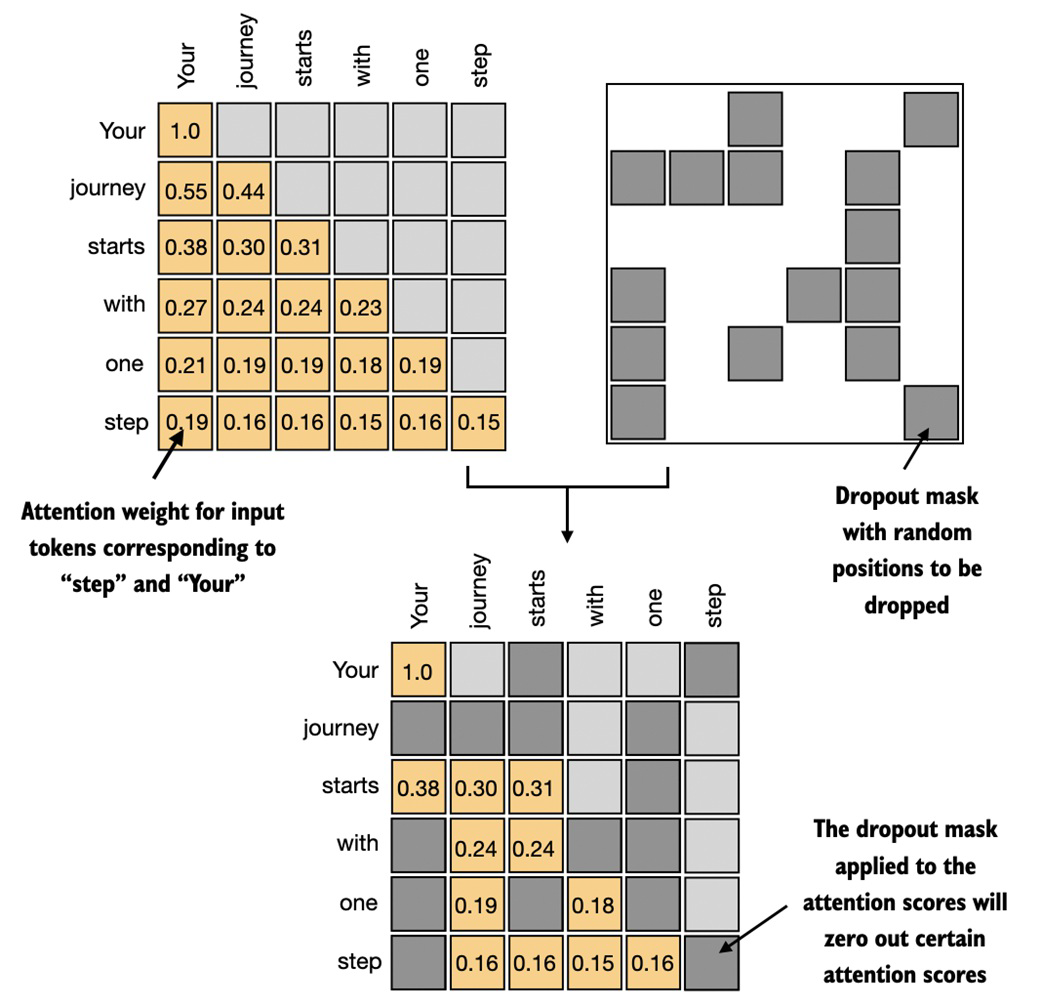

In [ ]:
# create drop out layer with treshould of 0.2
dropout=nn.Dropout(0.2)
# apply dropout on attention_weights, the remain values will scaled of 1/0.2= 5
dropout(masked_attention_weights)

tensor([[1.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6613, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4104, 0.4213, 0.4184, 0.0000, 0.0000, 0.0000],
        [0.3087, 0.3170, 0.3117, 0.3126, 0.0000, 0.0000],
        [0.2518, 0.2515, 0.2470, 0.0000, 0.2497, 0.0000],
        [0.2098, 0.2045, 0.2065, 0.2085, 0.2084, 0.2123]],
       grad_fn=<MulBackward0>)

## Causal Attention Class + Dropout

In [ ]:
class CausalAttention(nn.Module):
  def __init__(self,in_dim,out_dim,context_lenght,p_dropout=0.5,b_kqv=False):
    super().__init__()
    self.w_key=nn.Linear(in_dim,out_dim,b_kqv)
    self.w_query=nn.Linear(in_dim,out_dim,b_kqv)
    self.w_value=nn.Linear(in_dim,out_dim,b_kqv)
    self.dropout=nn.Dropout(p_dropout)
    self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_lenght,context_lenght),diagonal=1)
    )
  def forward(self,X):
    att_weights=self.__attention_weights(X)
    context_vects=self.__context_vects(X,att_weights)
    return context_vects
  def __attention_weights(self,X):
    # X shape (c,a,b)
    _,nbr_tokens_,_=X.shape
    keys=self.w_key(X)
    queries=self.w_query(X)
    scores=queries @ keys.transpose(1,2) # a=1,b=2
    scores.masked_fill_(
        self.mask.bool()[:nbr_tokens_,:nbr_tokens_],-torch.inf
    )
    masked_weight_att=torch.softmax(scores/keys.shape[-1]**0.5,dim=-1)
    drop_masked_weight_att=self.dropout(masked_weight_att)
    return drop_masked_weight_att
  def __context_vects(self,X,att_weights):
    values=self.w_value(X)
    return att_weights @ values

In [ ]:
# what triu do:
torch.triu(torch.ones(6,6),diagonal=1).bool()

tensor([[False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]])

In [ ]:
# create Batch to test
X=torch.stack((embed_mat.weight,embed_mat.weight))
print(X.shape)

torch.Size([2, 6, 3])


In [ ]:
causal_attention=CausalAttention(3,2,6,0.2)
causal_attention.forward(X)

tensor([[[-1.0245, -1.1985],
         [ 0.0286, -0.4784],
         [-0.3766, -0.8396],
         [-0.4694, -0.6234],
         [-0.3828, -0.8417],
         [-0.5912, -0.6508]],

        [[-1.0245, -1.1985],
         [ 0.0000,  0.0000],
         [-0.3766, -0.8396],
         [-0.4694, -0.6234],
         [-0.2372, -0.6715],
         [-0.3996, -0.4968]]], grad_fn=<UnsafeViewBackward0>)

## Multy Head Attention:
  - Implementing multi-head attention involves creating multiple instances of the self-attention mechanism

  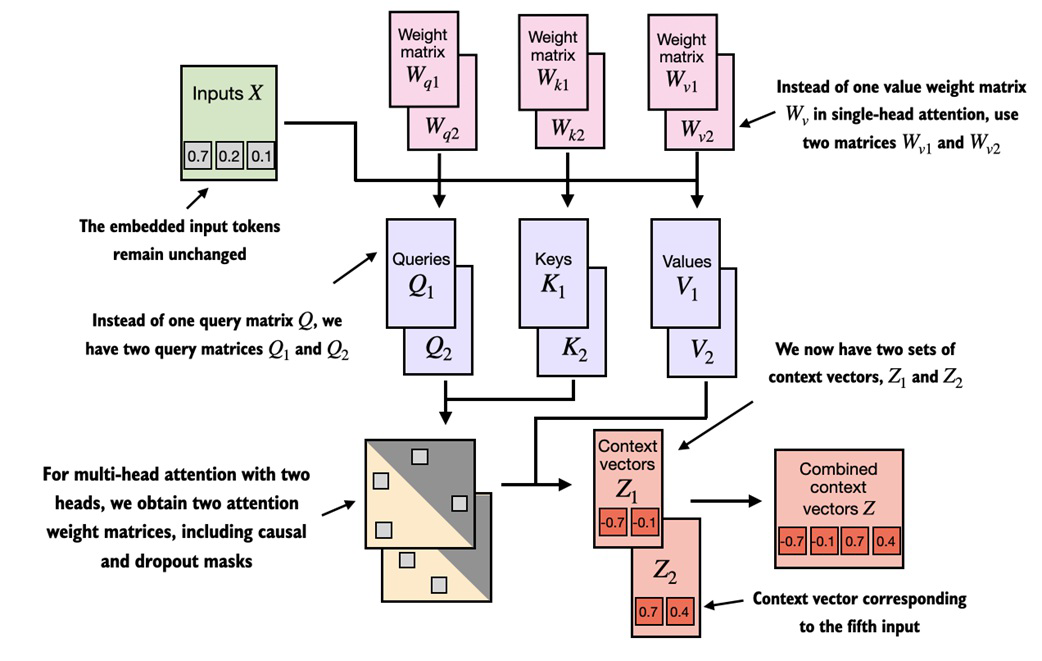

In [ ]:
class MultiheadAttentionWrapper(nn.Module):
  def __init__(self,in_dim,out_dim,context_lenght,num_head,p_drop=0.5,b_kqv=False):
    super().__init__()
    self.heads=nn.ModuleList([CausalAttention(in_dim,out_dim,context_lenght,p_drop,b_kqv) for _ in range(num_head)])
  def forward(self,X):
    context_vects=torch.cat([head(X) for head in self.heads],dim=-1) # cincatenation of context vects
    return context_vects

In [ ]:
X.shape

torch.Size([2, 6, 3])

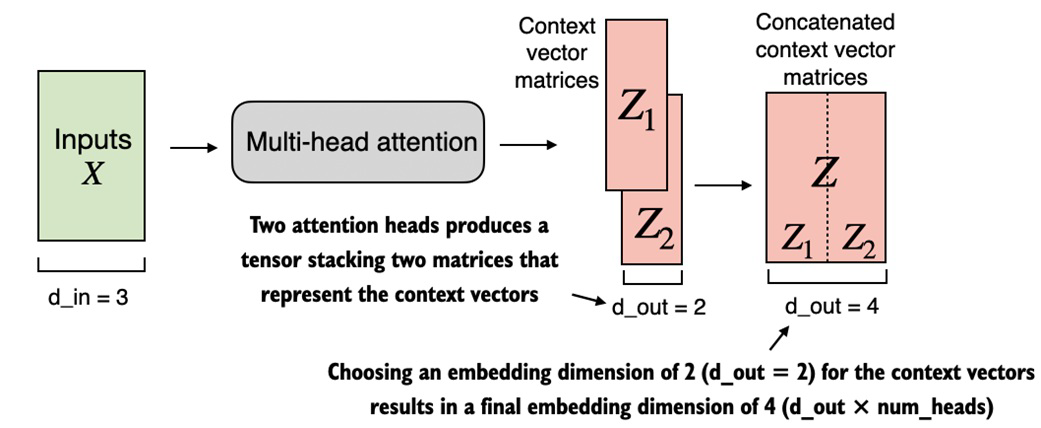

In [ ]:
multi_head_attention=MultiheadAttentionWrapper(3,2,6,2,0.0)
multi_head_attention

MultiheadAttentionWrapper(
  (heads): ModuleList(
    (0-1): 2 x CausalAttention(
      (w_key): Linear(in_features=3, out_features=2, bias=False)
      (w_query): Linear(in_features=3, out_features=2, bias=False)
      (w_value): Linear(in_features=3, out_features=2, bias=False)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
)

In [ ]:
mha_context_vect=multi_head_attention(X)
print(f"shape of mha_cont_vect: {mha_context_vect.shape}")
print(multi_head_attention(X))

shape of mha_cont_vect: torch.Size([2, 6, 4])
tensor([[[-0.1266,  0.0054, -0.9542,  0.2208],
         [ 0.5030, -0.1789, -0.4727, -0.3070],
         [ 0.3512, -0.3126, -0.4005, -0.3032],
         [ 0.2870, -0.3021, -0.3173, -0.2966],
         [ 0.3748, -0.3330, -0.3249, -0.2888],
         [ 0.1728, -0.2544, -0.4374, -0.1530]],

        [[-0.1266,  0.0054, -0.9542,  0.2208],
         [ 0.5030, -0.1789, -0.4727, -0.3070],
         [ 0.3512, -0.3126, -0.4005, -0.3032],
         [ 0.2870, -0.3021, -0.3173, -0.2966],
         [ 0.3748, -0.3330, -0.3249, -0.2888],
         [ 0.1728, -0.2544, -0.4374, -0.1530]]], grad_fn=<CatBackward0>)


## MultiHead Attentions wit Causual Att in One class
The reason is that we only need one matrix multiplication to compute the keys, for instance,
*  keys = self.W_key(x) (the same is true for the queries and values).

In the MultiHeadAttentionWrapper, we needed to **repeat this matrix multiplication**, which is computationally one of the most expensive steps, for each attention head.

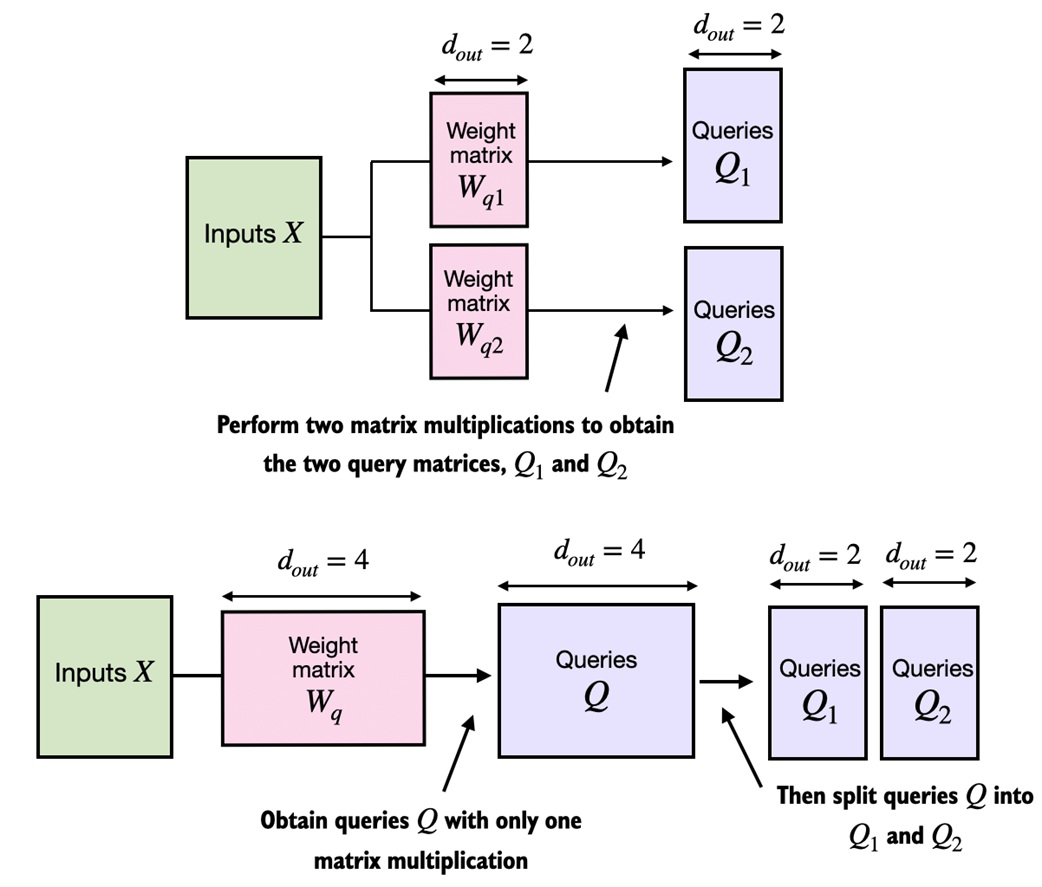

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self,d_in,d_out,context_length,num_heads,p_drop=0.5,b_kqv=False):
    super().__init__()
    assert d_out%num_heads==0 , "d_out must be divisible by num_heads"
    self.d_out=d_out
    self.num_heads=num_heads
    self.head_out=d_out//num_heads
    self.context_length=context_length
    self.w_key=nn.Linear(d_in,d_out,bias=b_kqv)
    self.w_query=nn.Linear(d_in,d_out,bias=b_kqv)
    self.w_value=nn.Linear(d_in,d_out,bias=b_kqv)
    self.drop_out=nn.Dropout(p_drop)
    self.register_buffer("mask",
                         torch.triu(
                             torch.ones(context_length,context_length)
                         ))
    self.out_proj=nn.Linear(d_out,d_out)

  def forward(self,X):
    b,nbr_tokens,embed_out=X.shape
    keys=self.w_key(X)
    queries=self.w_query(X)
    values=self.w_value(X)
    # change the shape of k,q,v to be batch , context len, number of heads and head out
    keys=keys.view(b,nbr_tokens,self.num_heads,self.head_out)
    queries=queries.view(b,nbr_tokens,self.num_heads,self.head_out)
    values=values.view(b,nbr_tokens,self.num_heads,self.head_out)
    # transpose heads with nbr of tokens or context len
    keys=keys.transpose(1,2)
    queries=queries.transpose(1,2)
    values=values.transpose(1,2)
    # calculate attention scores
    att_scores=queries @ keys.transpose(2,3)
    # causual Attention
    mask_bool=self.mask.bool()[:nbr_tokens,:nbr_tokens]
    att_scores.masked_fill_(mask_bool,-torch.inf)
    # weigthts causual attentions
    att_weights=torch.softmax(att_scores/keys.shape[-1]**0.5,dim=-1) # b,head,token,head_out
    # drop out
    att_weights=dropout(att_weights)
    # context vector
    context_vect=(attention_weights @ values).transpose(1,2)
    context_vect=context_vect.contiguous().view(b,nbr_tokens,self.d_out) # b,token, context_vect  (num_heads * self.head_out)
    return self.out_proj(context_vect)

In [ ]:
torch.manual_seed(123)
nbr_heads=3
dim_in=3
dim_out=9
context_len=6
mha=MultiHeadAttention(dim_in,dim_out,context_len,nbr_heads,0.0)
mha(X)

tensor([[[-0.2738,  0.2054,  0.3932,  0.3509,  0.2544,  0.3196,  0.2994,
           0.2166, -0.0341],
         [-0.3041,  0.2520,  0.4038,  0.3763,  0.4010,  0.2805,  0.3929,
           0.1542, -0.0243],
         [-0.2774,  0.2173,  0.3956,  0.3339,  0.2472,  0.3157,  0.3113,
           0.2186, -0.0446],
         [-0.2788,  0.2166,  0.3963,  0.3420,  0.2623,  0.3141,  0.3152,
           0.2128, -0.0404],
         [-0.2728,  0.2055,  0.3925,  0.3467,  0.2457,  0.3207,  0.2968,
           0.2198, -0.0361],
         [-0.2651,  0.1945,  0.3906,  0.3357,  0.2024,  0.3313,  0.2728,
           0.2383, -0.0416]],

        [[-0.2738,  0.2054,  0.3932,  0.3509,  0.2544,  0.3196,  0.2994,
           0.2166, -0.0341],
         [-0.3041,  0.2520,  0.4038,  0.3763,  0.4010,  0.2805,  0.3929,
           0.1542, -0.0243],
         [-0.2774,  0.2173,  0.3956,  0.3339,  0.2472,  0.3157,  0.3113,
           0.2186, -0.0446],
         [-0.2788,  0.2166,  0.3963,  0.3420,  0.2623,  0.3141,  0.3152,
       

# Build GPT

## GPT 124M Configs

In [ ]:
GPT_CONFIG_124={
    "vocab_size":50257,
    "context_length":1024,
    "embed_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

## Dummy GPT Model

In [ ]:
class DummyGPT(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_embed=nn.Embedding(cfg["vocab_size"],cfg["embed_dim"])
    self.pos_embed=nn.Embedding(cfg["context_length"],cfg["embed_dim"])
    self.drop_embed=nn.Dropout(cfg["drop_rate"])
    self.trfs_blocks=nn.Sequential(
        *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm=DummyLayerNorm(cfg["embed_dim"])
    self.out_head=nn.Linear(cfg["embed_dim"],cfg["vocab_size"])
  def forward(self,in_idx):
    b,seq_len=in_idx.shape
    tok_embeds=self.tok_embed(in_idx)
    pos_embeds=self.pos_embed(torch.arange(seq_len))
    x=tok_embeds+pos_embeds
    x=self.drop_embed(x)
    x=self.trfs_blocks(x)
    print(x.shape)
    x=self.final_norm(x)
    logits=self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
  def forward(self,X):
    return X
class DummyLayerNorm(nn.Module):
  def __init__(self,norm_shape,eps=1e-5):
    super().__init__()
  def forward(self,X):
    return X

In [ ]:
# Test
txt1="Every effort moves you"
txt2="Every day holds a"
# Toknizer
tokenizer=tiktoken.get_encoding("gpt2")
# create data batch
batch=[]
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch=torch.stack(batch,dim=0)
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [ ]:
dummy_gpt=DummyGPT(GPT_CONFIG_124)

In [ ]:
forward_result=dummy_gpt(batch)
forward_result

torch.Size([2, 4, 768])


tensor([[[-1.0529, -1.1995, -1.0470,  ..., -0.7629, -0.1507, -1.0347],
         [ 0.9355, -0.0478,  0.6913,  ..., -0.5080,  0.5703,  1.7510],
         [ 0.8241,  1.1985,  0.4785,  ...,  0.4595,  0.7753,  0.1230],
         [ 0.2204,  1.6062,  0.6229,  ...,  1.0001, -0.8583, -0.6571]],

        [[-0.7688, -1.2553, -0.7255,  ..., -1.0675,  0.1393, -0.5366],
         [-0.2721, -0.5651,  0.1719,  ..., -0.2033,  0.4275,  0.6102],
         [ 0.6865,  0.4919, -1.1950,  ..., -0.7661,  0.1268,  0.6135],
         [ 0.0589,  0.3413, -0.1374,  ...,  2.5130, -0.0610, -0.3327]]],
       grad_fn=<ViewBackward0>)

In [ ]:
forward_result.shape

torch.Size([2, 4, 50257])

In [ ]:
tokenizer.decode([13467])

' trusted'

In [ ]:
int(torch.argmax(forward_result[0,0]))

31025

## Normalization

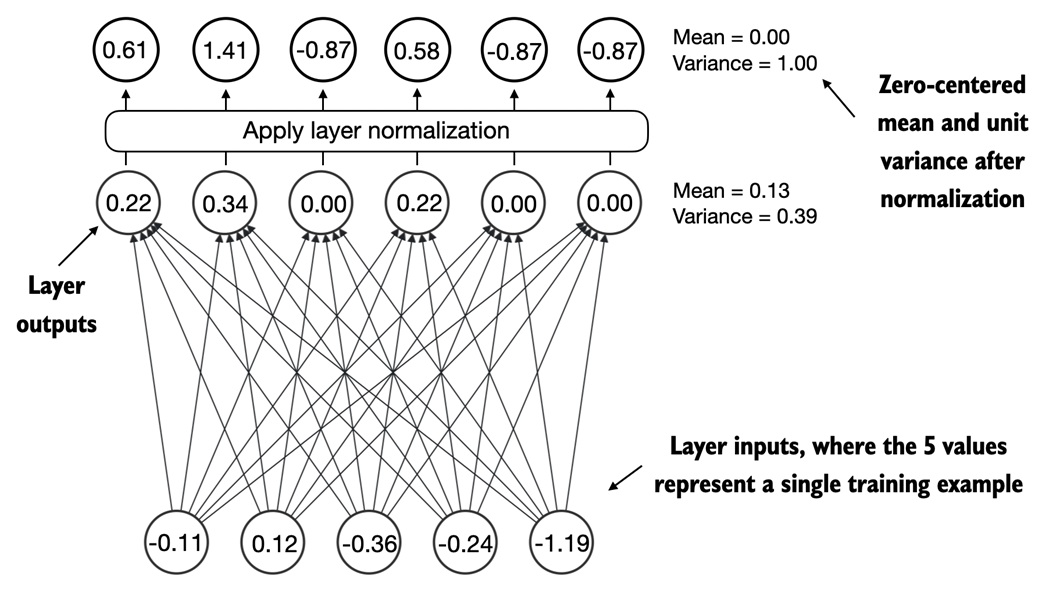

In [ ]:
torch.manual_seed(123)
batch_example=torch.randn(2,5)
layers=nn.Sequential(nn.Linear(5,6),nn.ReLU())
out=layers(batch_example)

In [ ]:
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [ ]:
# calculate the mean and variance
mean=out.mean(dim=-1,keepdim=True)
var=out.var(dim=-1,keepdim=True)
print(f"mean \n {mean}")
print(f"var \n {var}")

mean 
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
var 
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [ ]:
# llayer normalization
out_norm=(out - mean)/torch.sqrt(var) #standard deviation
mean=out_norm.mean(dim=-1,keepdim=True)
var=out_norm.var(dim=-1,keepdim=True)
print("out norm ", out_norm)
torch.set_printoptions(sci_mode=False)
print(mean)
print(var)

out norm  tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
tensor([[    -0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### Layer Normalization class

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self,embed_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.zeros(embed_dim))
    self.shift=nn.Parameter(torch.ones(embed_dim))
  def forward(self,x):
    x_mean=x.mean(dim=-1,keepdim=True)
    x_var=x.var(dim=-1,keepdim=True,unbiased=True)
    norm_x=(x-mean)/torch.sqrt(x_var+self.eps)
    return self.shift*norm_x+self.scale

In [ ]:
out_layer=LayerNorm(5)(batch_example)
out_layer

tensor([[-0.2221,  0.2398, -0.7366, -0.4791, -2.3851],
        [ 0.3620, -1.6821, -1.3061,  0.5603, -0.1877]], grad_fn=<AddBackward0>)

In [ ]:
out_layer.mean(dim=-1,keepdim=True) , out_layer.var(dim=-1,keepdim=True)


(tensor([[-0.7166],
         [-0.4507]], grad_fn=<MeanBackward1>),
 tensor([[1.0000],
         [1.0000]], grad_fn=<VarBackward0>))